In [1]:
import nbimporter # to import methods from another notebook
import manta_file_processing as mfp
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import time
import random
import os

Importing Jupyter notebook from manta_file_processing.ipynb


In [2]:
heatmap_order=("left-eye","right-eye","left-gill","right-gill","tail")

In [3]:
from importlib import reload
reload(mfp)

Importing Jupyter notebook from manta_file_processing.ipynb


<module 'manta_file_processing' from 'manta_file_processing.ipynb'>

In [4]:
if os.name=="nt":
    folder="C:\\YandexDisk\\_QUT\\Project_1\\MAntas_imag\\0_manta_selected_annotated_some"
else:
    folder="/tf/notebooks/data/0_manta_selected_annotated_some"
print("os = "+os.name)
print("folder: "+folder+"\n ---\ncollecting...")
dataset=mfp.get_manta_files(folder=folder)

os = nt
folder: C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_manta_selected_annotated_some
 ---
collecting...
total:1801
labelled:295


In [5]:
df=dataset[dataset.body_landmark_path.isnull()==False].sample(frac=1)
manta_data=np.array(df[["image_path","body_landmark_path"]])
#data=np.array([df.image_path,df.body_landmark_path])
manta_data.shape

(295, 2)

In [6]:
image_size=[100,100]
heatmap_size=[17,17]

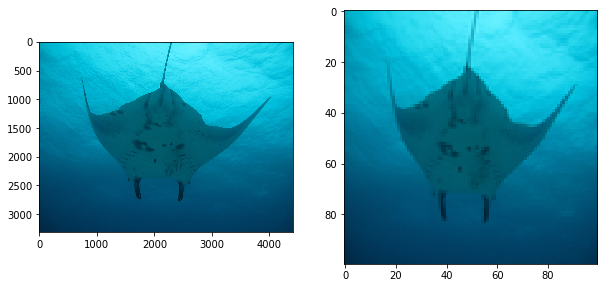

In [7]:
im_path,blm_path = manta_data[56]
image = Image.open(im_path)
body_landmarks=mfp.extract_body_landmarks(blm_path)
heatmaps=mfp.gen_heatmaps(body_landmarks,image_size)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 10))
axes[0].imshow(image)

image1=mfp.image_to_numpy(image,image_size)
axes[1].imshow(mfp.denormalize(image1))    
#axes[2].imshow(image[:,::-1])   
plt.show()


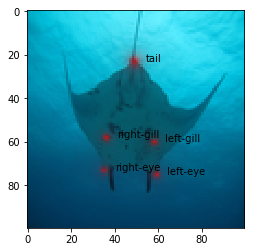

In [8]:
mfp.apply_heatmaps(mfp.denormalize(image1),heatmaps)

In [9]:
def flip_image(image,heatmaps):
    flip_image=image[::-1,:,]
    flip_heatmap=heatmaps[::-1,:,]
    return flip_image,flip_heatmap

In [10]:
X=[]
y=[]
i=0
print ("total:" + str(manta_data.shape[0]))

for im_path,blm_path in manta_data:#[:20]:
    try:
        image = Image.open(im_path)
        body_landmarks=mfp.extract_body_landmarks(blm_path)
    except:
        print(" \n Error on "+blm_path)
        
    image=mfp.image_to_numpy(image,image_size)
    if image.shape[2]>3:
        image=image[:,:,:3]
    numpy_heatmaps=mfp.gen_heatmaps(body_landmarks,heatmap_size=heatmap_size)
    #numpy_heatmaps=mfp.heatmaps_to_numpy(heatmaps)
    
    #if image.shape[2]>3:
    #    image=image[:,:,:3]
        #print("\n More then 3 channels")
        #print(blm_path)
        #numpy_heatmaps=None
    
    if numpy_heatmaps is not None and numpy_heatmaps.sum()>0:
        y.append(numpy_heatmaps[:,:,:2])
        X.append(image) 
        #flip_img, flip_hm=flip_image(image,numpy_heatmaps)
        #y.append(flip_hm[:,:,:2])
        #X.append(flip_img) 
        
    print(i,end=" ")
    i+=1

X=np.array(X)
y=np.array(y)
print("\n====================")
print("Done.\nX.shape="+str(X.shape))
print("y.shape="+str(y.shape))


total:295
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 

KeyboardInterrupt: 

In [ ]:
n=10
samples=random.sample(list(np.arange(X.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=2,figsize=(10, 30))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(mfp.denormalize(X[s]))
    axes[i,1].imshow(y[s].sum(axis=2),cmap='Greys')
plt.show()

In [ ]:
i=100
mfp.apply_heatmaps(mfp.denormalize(X[i]),y[i])
    

In [17]:
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense,Conv2DTranspose
from tensorflow.python.keras.layers import BatchNormalization,AveragePooling2D,Activation

from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import Adam

In [19]:
import copy
input_shape=copy.copy(image_size)
input_shape.append(3)
batch_size=8
nb_train_samples=int(round(X.shape[0]*0.95,0))
X_train=X[:nb_train_samples]
X_test =X[nb_train_samples:]
y_train=y[:nb_train_samples]
y_test =y[nb_train_samples:]

In [20]:
#pip install h5py
#pip install cython
#restart jupyther
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)
vgg16_net.trainable = False

In [21]:
from tensorflow.keras.models import Model
mymodel = Model(vgg16_net.get_input_at(0), vgg16_net.layers[17].get_output_at(0))
mymodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [22]:
model=Sequential()
model.add(vgg16_net)
#model.add(mymodel)

model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=64,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=32,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=2,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 3, 512)         2048      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 64)          294976    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 15, 15, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 17, 17, 2)         578       
__________

In [23]:
model.compile(loss='binary_crossentropy',
optimizer='adam',
metrics=['binary_accuracy'])

In [32]:
start_time = time.time()

history=model.fit(X_train,y_train,batch_size=32,epochs=200,validation_split=0.1)

training_time=round(time.time() - start_time,2)

Train on 252 samples, validate on 28 samples
Epoch 1/200
252/252 [==============================] - 6s 22ms/step - loss: 0.5224 - binary_accuracy: 0.0853 - val_loss: 0.5140 - val_binary_accuracy: 0.0893
Epoch 2/200
252/252 [==============================] - 6s 22ms/step - loss: 0.5198 - binary_accuracy: 0.0853 - val_loss: 0.5123 - val_binary_accuracy: 0.0893
Epoch 3/200
252/252 [==============================] - 6s 22ms/step - loss: 0.5173 - binary_accuracy: 0.0853 - val_loss: 0.5109 - val_binary_accuracy: 0.0893
Epoch 4/200
252/252 [==============================] - 6s 22ms/step - loss: 0.5145 - binary_accuracy: 0.0853 - val_loss: 0.5077 - val_binary_accuracy: 0.0893
Epoch 5/200
252/252 [==============================] - 6s 22ms/step - loss: 0.5117 - binary_accuracy: 0.0853 - val_loss: 0.5064 - val_binary_accuracy: 0.0892
Epoch 6/200
252/252 [==============================] - 6s 22ms/step - loss: 0.5092 - binary_accuracy: 0.0853 - val_loss: 0.5050 - val_binary_accuracy: 0.0893
Epoch 7

252/252 [==============================] - 5s 22ms/step - loss: 0.3296 - binary_accuracy: 0.0853 - val_loss: 0.3335 - val_binary_accuracy: 0.0893
Epoch 104/200
252/252 [==============================] - 5s 22ms/step - loss: 0.3285 - binary_accuracy: 0.0853 - val_loss: 0.3321 - val_binary_accuracy: 0.0893
Epoch 105/200
252/252 [==============================] - 6s 22ms/step - loss: 0.3270 - binary_accuracy: 0.0853 - val_loss: 0.3311 - val_binary_accuracy: 0.0893
Epoch 106/200
252/252 [==============================] - 6s 22ms/step - loss: 0.3257 - binary_accuracy: 0.0853 - val_loss: 0.3307 - val_binary_accuracy: 0.0893
Epoch 107/200
252/252 [==============================] - 5s 22ms/step - loss: 0.3244 - binary_accuracy: 0.0853 - val_loss: 0.3292 - val_binary_accuracy: 0.0893
Epoch 108/200
252/252 [==============================] - 5s 22ms/step - loss: 0.3232 - binary_accuracy: 0.0853 - val_loss: 0.3279 - val_binary_accuracy: 0.0893
Epoch 109/200
252/252 [==============================]


Training time :'--- 18.0 min 23.579999999999927 sec ---


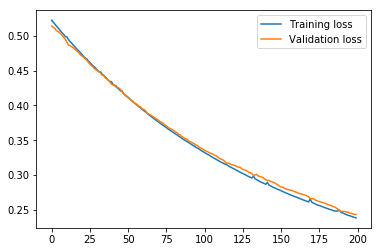

In [33]:
print("\nTraining time :'--- %s min %s sec ---" % (training_time//60,training_time%60) )
loss = history.history['loss']
val_loss= history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.show()

In [34]:
pred=model.predict(X_test)
print(X_test.shape)
print(pred.shape)

(15, 100, 100, 3)
(15, 17, 17, 2)


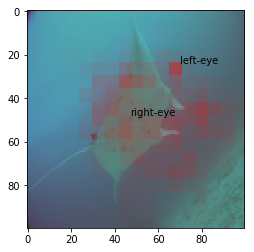

In [39]:
i=14
mfp.apply_heatmaps(mfp.denormalize(X_test[i]),pred[i])

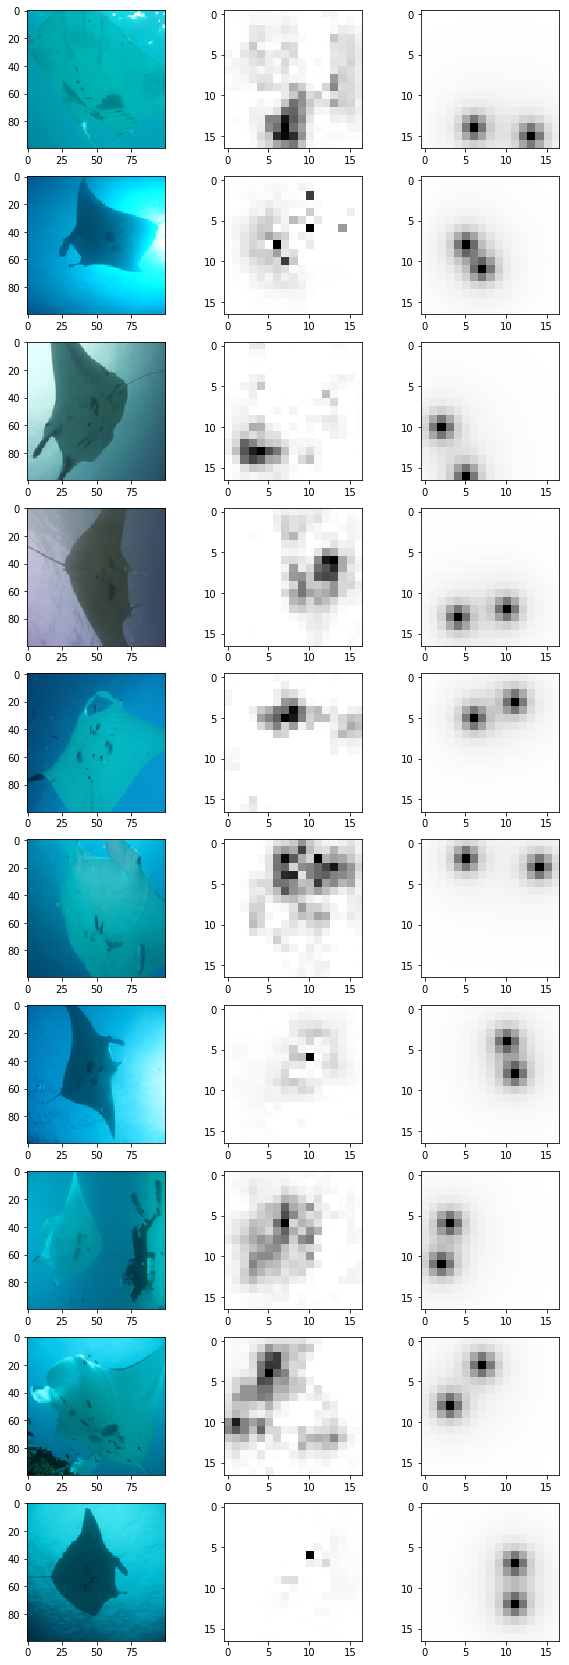

In [35]:
n=10#X_test.shape[0]
samples=random.sample(list(np.arange(pred.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=3,figsize=(10, 30))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(mfp.denormalize(X_test[s]))
    axes[i,1].imshow(pred[s].sum(axis=2),cmap='Greys')
    axes[i,2].imshow(y_test[s].sum(axis=2),cmap='Greys')
plt.show()

In [ ]:
# large heatmap
# Распределение Коши  1/(1+((x-xo)/r)**2)
+ validation set
+ get rid of maxPooling layer?
+ augmentation
+ labelling
